In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
import operator
import re
import string

c:\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df_schemes = pd.read_csv('../schemes.csv', encoding='mac_roman')
df_schemes.head()

,Scheme,Agency,Description,Link,Image,Tag 1,Tag 2,Tag 3
0,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with...,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,Caregiver,NaN,NaN
1,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons wit...,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,Caregiver,NaN,NaN
2,Food Assistance,A Packet of Rice,A self setup group which distributes meal box ...,https://www.facebook.com/APacketOfRice/,https://chidnast.sirv.com/SchemesSG/apacketofr...,Low Income,Food,NaN
3,Family LifeAid,Red Cross Singapore,Identified households receive food vouchers ev...,https://www.redcross.sg/get-assistance/family-...,https://chidnast.sirv.com/SchemesSG/redcross.jpg,Low Income,Food,Education
4,Financial Assistance,365 Cancer Prevention Society (365CPS),Cancer treatment can place a heavy financial b...,https://365cps.org.sg/portfolio/financial-supp...,https://chidnast.sirv.com/SchemesSG/365cps.jpg,Low Income,Healthcare,NaN


In [3]:
#Create tag list
df_schemes['Tags'] = [x for x in df_schemes[df_schemes.columns[5:8]].values]
df_schemes['Tags'] = df_schemes['Tags'].apply(lambda x: [i for i in x if str(i) != "nan"])
df_schemes

,Scheme,Agency,Description,Link,Image,Tag 1,Tag 2,Tag 3,Tags
0,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with...,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,Caregiver,NaN,NaN,[Caregiver]
1,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons wit...,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,Caregiver,NaN,NaN,[Caregiver]
2,Food Assistance,A Packet of Rice,A self setup group which distributes meal box ...,https://www.facebook.com/APacketOfRice/,https://chidnast.sirv.com/SchemesSG/apacketofr...,Low Income,Food,NaN,"[Low Income, Food]"
3,Family LifeAid,Red Cross Singapore,Identified households receive food vouchers ev...,https://www.redcross.sg/get-assistance/family-...,https://chidnast.sirv.com/SchemesSG/redcross.jpg,Low Income,Food,Education,"[Low Income, Food, Education]"
4,Financial Assistance,365 Cancer Prevention Society (365CPS),Cancer treatment can place a heavy financial b...,https://365cps.org.sg/portfolio/financial-supp...,https://chidnast.sirv.com/SchemesSG/365cps.jpg,Low Income,Healthcare,NaN,"[Low Income, Healthcare]"
...,...,...,...,...,...,...,...,...,...
108,The Straits Times School Pocket Money Fund,The Straits Times School Pocket Money Fund (SPMF),To alleviate the financial burden faced by par...,https://www.spmf.org.sg/primary-secondary-stud...,https://chidnast.sirv.com/SchemesSG/stspmf.jpg,Low Income,Education,NaN,"[Low Income, Education]"
109,Workfare Skills Support (WSS) Scheme,Workforce Singapore (WSG),WSS encourages low wage workers to undertake t...,https://www.wsg.gov.sg/programmes-and-initiati...,https://chidnast.sirv.com/SchemesSG/wsg.jpg,Work,NaN,NaN,[Work]
110,Career Matching Services,Workforce Singapore (WSG),"Access to quick career tips, career advice and...",https://www.wsg.gov.sg/career-services.html,https://chidnast.sirv.com/SchemesSG/wsg.jpg,Work,NaN,NaN,[Work]
111,Assistance,Yayasan MENDAKI,"Various education subsidies, bursaries, study ...",https://www.mendaki.org.sg/assistance-landing/,https://chidnast.sirv.com/SchemesSG/mendaki.jpg,Low Income,Education,NaN,"[Low Income, Education]"


In [4]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctuations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [8]:
%time df_schemes['Tags_tokenized'] = df_schemes['Description'].map(lambda x: spacy_tokenizer(x))

df_schemes

Wall time: 1.71 s


,Scheme,Agency,Description,Link,Image,Tag 1,Tag 2,Tag 3,Tags,Tags_tokenized
0,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with...,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,Caregiver,NaN,NaN,[Caregiver],"[provide, support, caregiver, person, mental, ..."
1,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons wit...,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,Caregiver,NaN,NaN,[Caregiver],"[provide, training, caregiver, person, mental,..."
2,Food Assistance,A Packet of Rice,A self setup group which distributes meal box ...,https://www.facebook.com/APacketOfRice/,https://chidnast.sirv.com/SchemesSG/apacketofr...,Low Income,Food,NaN,"[Low Income, Food]","[self, setup, group, distribute, meal, box, lo..."
3,Family LifeAid,Red Cross Singapore,Identified households receive food vouchers ev...,https://www.redcross.sg/get-assistance/family-...,https://chidnast.sirv.com/SchemesSG/redcross.jpg,Low Income,Food,Education,"[Low Income, Food, Education]","[identify, household, receive, food, voucher, ..."
4,Financial Assistance,365 Cancer Prevention Society (365CPS),Cancer treatment can place a heavy financial b...,https://365cps.org.sg/portfolio/financial-supp...,https://chidnast.sirv.com/SchemesSG/365cps.jpg,Low Income,Healthcare,NaN,"[Low Income, Healthcare]","[cancer, treatment, place, heavy, financial, b..."
...,...,...,...,...,...,...,...,...,...,...
108,The Straits Times School Pocket Money Fund,The Straits Times School Pocket Money Fund (SPMF),To alleviate the financial burden faced by par...,https://www.spmf.org.sg/primary-secondary-stud...,https://chidnast.sirv.com/SchemesSG/stspmf.jpg,Low Income,Education,NaN,"[Low Income, Education]","[alleviate, financial, burden, face, parent, p..."
109,Workfare Skills Support (WSS) Scheme,Workforce Singapore (WSG),WSS encourages low wage workers to undertake t...,https://www.wsg.gov.sg/programmes-and-initiati...,https://chidnast.sirv.com/SchemesSG/wsg.jpg,Work,NaN,NaN,[Work],"[wss, encourage, low, wage, worker, undertake,..."
110,Career Matching Services,Workforce Singapore (WSG),"Access to quick career tips, career advice and...",https://www.wsg.gov.sg/career-services.html,https://chidnast.sirv.com/SchemesSG/wsg.jpg,Work,NaN,NaN,[Work],"[access, quick, career, tip, career, advice, g..."
111,Assistance,Yayasan MENDAKI,"Various education subsidies, bursaries, study ...",https://www.mendaki.org.sg/assistance-landing/,https://chidnast.sirv.com/SchemesSG/mendaki.jpg,Low Income,Education,NaN,"[Low Income, Education]","[education, subsidy, bursary, study, loan, sch..."


In [9]:
Description_to_match = df_schemes['Tags_tokenized']
Description_to_match[0:5]

0    [provide, support, caregiver, person, mental, ...
1    [provide, training, caregiver, person, mental,...
2    [self, setup, group, distribute, meal, box, lo...
3    [identify, household, receive, food, voucher, ...
4    [cancer, treatment, place, heavy, financial, b...
Name: Tags_tokenized, dtype: object

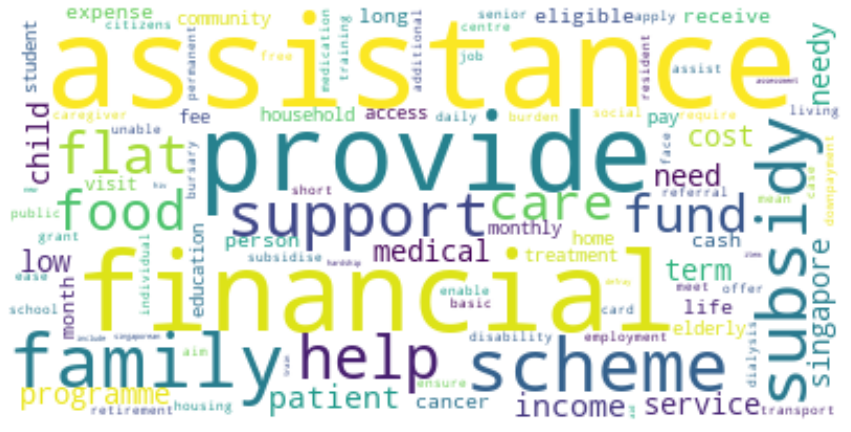

In [10]:
#Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(Description_to_match)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
#build word dictionary

from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(Description_to_match)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)
dictionary.save('dictionary')

Wall time: 7.02 ms


In [12]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['caregiver', 0], ['health', 1], ['issue', 2], ['mental', 3], ['person', 4], ['provide', 5], ['support', 6], ['training', 7], ['box', 8], ['bukit', 9], ['citizen', 10], ['distribute', 11], ['flat', 12], ['group', 13], ['income', 14], ['low', 15], ['meal', 16], ['merah', 17], ['near', 18], ['needy', 19], ['operates', 20], ['region', 21], ['rent', 22], ['reside', 23], ['resident', 24], ['room', 25], ['self', 26], ['senior', 27], ['setup', 28], ['addition', 29], ['advance', 30], ['assessment', 31], ['benefit', 32], ['carry', 33], ['change', 34], ['child', 35], ['chore', 36], ['condition', 37], ['dire', 38], ['ensure', 39], ['family', 40], ['familyí', 41], ['food', 42], ['help', 43], ['household', 44], ['households', 45], ['identify', 46], ['improvement', 47], ['life', 48], ['meet', 49], ['monitor', 50]]]


In [13]:
#Bag of words
corpus = [dictionary.doc2bow(desc) for desc in Description_to_match]
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]
print(word_frequencies)

[[('caregiver', 1), ('health', 1), ('issue', 1), ('mental', 1), ('person', 1), ('provide', 1), ('support', 1)], [('caregiver', 1), ('health', 1), ('issue', 1), ('mental', 1), ('person', 1), ('provide', 1), ('training', 1)], [('box', 1), ('bukit', 1), ('citizen', 1), ('distribute', 1), ('flat', 1), ('group', 1), ('income', 1), ('low', 1), ('meal', 1), ('merah', 1), ('near', 1), ('needy', 1), ('operates', 1), ('region', 1), ('rent', 1), ('reside', 1), ('resident', 1), ('room', 1), ('self', 1), ('senior', 1), ('setup', 1)]]


In [14]:
#TF IDF and LSI
%time schemes_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
schemes_tfidf_model.save("tfidf.model")
%time schemes_lsi_model = gensim.models.LsiModel(schemes_tfidf_model[corpus], id2word=dictionary, num_topics=300)
schemes_lsi_model.save("lsi.model")

Wall time: 5.98 ms
Wall time: 428 ms


In [15]:
%time gensim.corpora.MmCorpus.serialize('schemes_tfidf_model_mm', schemes_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('schemes_lsi_model_mm',schemes_lsi_model[schemes_tfidf_model[corpus]])

Wall time: 34.9 ms
Wall time: 62.8 ms


In [16]:
#Load indexed corpus
schemes_tfidf_corpus = gensim.corpora.MmCorpus('schemes_tfidf_model_mm')
schemes_lsi_corpus = gensim.corpora.MmCorpus('schemes_lsi_model_mm')

print(schemes_tfidf_corpus)
print(schemes_lsi_corpus)

MmCorpus(113 documents, 910 features, 2140 non-zero entries)
MmCorpus(113 documents, 112 features, 12656 non-zero entries)


In [17]:
from gensim.similarities import MatrixSimilarity

%time schemes_index = MatrixSimilarity(schemes_lsi_corpus, num_features = schemes_lsi_corpus.num_terms)

Wall time: 40.9 ms


In [22]:
#Search similarity

from operator import itemgetter

def search_similar_schemes(search_term):
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = schemes_tfidf_model[query_bow]
    query_lsi = schemes_lsi_model[query_tfidf]

    schemes_index.num_best = 50

    schemes_list = schemes_index[query_lsi]

    schemes_list.sort(key=itemgetter(1), reverse=True)
    schemes_names = []

    for j, scheme in enumerate(schemes_list):

        schemes_names.append (
            {
                'Relevance': round((scheme[1] * 100),2),
                'Scheme Title': df_schemes['Scheme'][scheme[0]],
                'Description': df_schemes['Description'][scheme[0]]
            }

        )
        if j == (schemes_index.num_best-1):
            break

    return pd.DataFrame(schemes_names, columns=['Relevance','Scheme Title','Description'])

In [23]:
search_similar_schemes('my client needs help as their family has lost a breadwinner and they need money to help with daily necessities during COVID. The child is also unable to afford schooling supplies such as computer')

,Relevance,Scheme Title,Description
0,42.70,Food Care Programme,Food Care Programme provides food and daily ne...
1,35.21,COVID 19 related support,Key government resource on COVID-19 related as...
2,33.53,NEU PC Plus,The NEU PC Plus programme supports low-income ...
3,31.51,Compassion Fund,"Assist students whose families are in crisis, ..."
4,30.82,COVID-19 - Family Assistance Fund,Covid 19 Family Assistance Fund Fund will go t...
5,28.89,Care for Family Fund,Many people who are diagnosed with HIV will lo...
6,26.89,"Cancer Care Fund, Welfare Aid Fund, Cancer Tre...",The Cancer Care Fund is a one-time financial a...
7,25.94,Various Programmes and Services,Various financial support schemes for medical ...
8,25.51,Neighbourhood Assistance Fund (NAF),The Neighbourhood Assistance Fund seeks to pro...
9,23.67,ComCare Short-To-Medium-Term Assistance,Short to medium term assistance for those unab...


In [24]:
import flask
print(flask.__version__)

1.1.2
